Num GPUs Available:  1
Epoch 1/10
697/697 [==============================] - 6s 7ms/step - loss: 55061140.0000
Epoch 2/10
697/697 [==============================] - 5s 6ms/step - loss: 53114744.0000
Epoch 3/10
697/697 [==============================] - 4s 6ms/step - loss: 50021580.0000
Epoch 4/10
697/697 [==============================] - 4s 6ms/step - loss: 46288792.0000
Epoch 5/10
697/697 [==============================] - 5s 7ms/step - loss: 42215032.0000
Epoch 6/10
697/697 [==============================] - 4s 6ms/step - loss: 38035360.0000
Epoch 7/10
697/697 [==============================] - 4s 6ms/step - loss: 33948220.0000
Epoch 8/10
697/697 [==============================] - 4s 6ms/step - loss: 30098170.0000
Epoch 9/10
697/697 [==============================] - 4s 6ms/step - loss: 26584366.0000
Epoch 10/10
697/697 [==============================] - 4s 6ms/step - loss: 23481926.0000


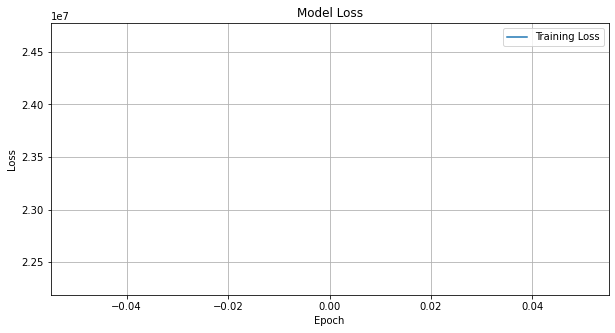

In [18]:
import tensorflow as tf
import pandas as pd
import numpy as np

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

def load_data(he_features_path, codex_features_path):
    he_features = pd.read_csv(he_features_path)
    codex_features = pd.read_csv(codex_features_path)
    
    # Check for NaNs and replace them
    he_features = he_features.select_dtypes(include=[np.number]).astype(np.float32)
    codex_features = codex_features.select_dtypes(include=[np.number]).astype(np.float32)

    # Fill NaN values
    he_features.fillna(he_features.mean(), inplace=True)
    codex_features.fillna(codex_features.mean(), inplace=True)

    return he_features.values, codex_features.values


def prepare_dataset(he_features, codex_features, batch_size=32):
    """ Prepare a TensorFlow dataset for training with sequence dimension added """
    # Reshape the data to include a sequence dimension
    he_features_tensor = tf.reshape(he_features, (-1, 1, he_features.shape[1]))  # Add sequence length of 1
    codex_features_tensor = tf.reshape(codex_features, (-1, 1, codex_features.shape[1]))

    dataset = tf.data.Dataset.from_tensor_slices((he_features_tensor, codex_features_tensor))
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset


class PositionalEncodingLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, **kwargs):
        super(PositionalEncodingLayer, self).__init__(**kwargs)
        self.d_model = d_model

    def get_angles(self, pos, i, d_model):
        # Cast everything to float32 to ensure consistent data types in operations
        pos = tf.cast(pos, tf.float32)
        i = tf.cast(i, tf.float32)
        d_model = tf.cast(d_model, tf.float32)
        angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / d_model)
        return pos * angle_rates

    def call(self, inputs):
        position = tf.shape(inputs)[1]
        d_model = tf.shape(inputs)[2]
        
        pos = tf.range(position)[:, tf.newaxis]
        i = tf.range(d_model)[tf.newaxis, :]
        angle_rads = self.get_angles(pos, i, d_model)

        sines = tf.sin(angle_rads[:, 0::2])
        cosines = tf.cos(angle_rads[:, 1::2])
        
        # Combine sines and cosines back into one tensor and reshape
        angle_rads = tf.concat([sines, cosines[:, :sines.shape[-1]]], axis=-1)
        pos_encoding = tf.reshape(angle_rads, (1, position, d_model))

        return inputs + pos_encoding

def build_transformer(num_features, num_codex_features, num_heads=8, dim_feedforward=2048, num_layers=3, dropout=0.1):
    """ Build a transformer model using TensorFlow Keras with a custom positional encoding layer """
    input_layer = tf.keras.layers.Input(shape=(1, num_features))  # Ensure this matches the new data shape
    x = PositionalEncodingLayer(num_features)(input_layer)
    
    for _ in range(num_layers):
        x = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=num_features, dropout=dropout)(x, x)
        x = tf.keras.layers.Dropout(dropout)(x)
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        x = tf.keras.layers.Dense(dim_feedforward, activation='relu')(x)
        x = tf.keras.layers.Dense(num_features)(x)
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

    output_layer = tf.keras.layers.Dense(num_codex_features)(x)
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model


import tensorflow as tf
import os

def compile_and_train(model, dataset, val_dataset, epochs=10):
    """
    Compile and train the model with functionality to generate and save feature vectors every 25 epochs.
    Args:
        model: The TensorFlow model to be trained.
        dataset: The dataset used for training.
        val_dataset: The dataset used for validation.
        epochs: Total number of epochs for training.

    Returns:
        The training history object.
    """
    model.compile(optimizer='adam', loss='mse')
    
    # Directory for saving feature vectors
    os.makedirs("feature_vectors", exist_ok=True)
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        history = model.fit(dataset, validation_data=val_dataset, epochs=1)  # Train one epoch at a time

        # Generate and save feature vector every 25 epochs
        if (epoch + 1) % 25 == 0:
            feature_vector = generate_feature_vector(model)
            save_feature_vector(feature_vector, epoch + 1)

    return history

def generate_feature_vector(model):
    """
    Generate a feature vector using the trained model.
    Assume using some fixed or dummy input to get the feature vector.
    """
    dummy_input = tf.random.normal([1, 1, model.input_shape[-1]])  # Adjust dimensions as necessary
    feature_vector = model.predict(dummy_input)
    return feature_vector

def save_feature_vector(feature_vector, epoch):
    """
    Save the feature vector to a file.
    Args:
        feature_vector: The feature vector to save.
        epoch: The current epoch number to include in the filename.
    """
    # Ensure the feature vector is 2D
    if len(feature_vector.shape) > 2:
        feature_vector = feature_vector.squeeze()  # Try to remove single-dimensional entries from the shape
    if len(feature_vector.shape) == 1:
        feature_vector = feature_vector.reshape(1, -1)  # Make it 2D explicitly if it's 1D

    filename = f"feature_vectors/transformer_column_epoch_{epoch}.csv"
    np.savetxt(filename, feature_vector, delimiter=",")
    print(f"Saved feature vector at epoch {epoch} to {filename}")
    

def plot_loss(history):
    """
    Plot the training and validation loss from the model's history.
    Args:
        history: A TensorFlow history object.
    """
    if 'loss' not in history.history:
        print("No training loss data to plot.")
    else:
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'], label='Training Loss')
        
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], label='Validation Loss')
        
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        plt.grid(True)
        plt.show()
# Paths to data
he_features_path = "/home/j.maragall/Pipeline_CellMapping/ae_unique_extracted_features.csv"
codex_features_path = "/home/j.maragall/PRESENTATION_FEATURES.csv"

he_features, codex_features = load_data(he_features_path, codex_features_path)
dataset = prepare_dataset(he_features, codex_features)
model = build_transformer(num_features=he_features.shape[1], num_codex_features=codex_features.shape[1])
# Assuming 'model', 'dataset', and potential 'val_dataset' are already defined
history = compile_and_train(model, dataset, None)  # Modify as necessary if you have a validation dataset

plot_loss(history)
